In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler 
from transformers import AutoTokenizer
from sklearn.model_selection import KFold

data = []
label = []

f = open('dataset_1192.txt')
record = f.read().split('\n')
for r in record:
    data.append(r.split('\t')[0])
    label.append(r.split('\t')[1])
    
df = pd.DataFrame({'Data':data,'Label':label})
texts = list(df.Data)
label = np.array(df.Label.astype('int'))
number_label = df.Label.astype('category').cat.categories


In [ ]:
training_sizes = [200,400,600,800,1000,1192]
Xs=[]
Ys=[]
for s in training_sizes :
  Xs.append(texts[0:s])
  Ys.append(label[0:s])

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from transformers import AutoConfig
from transformers import AdamW
from sklearn.metrics import f1_score
import random
import numpy as np
import os
import time
import datetime
import random

# "bert-base-cased"
# "distilbert-base-uncased"
# "dmis-lab/biobert-v1.1" 


data_set = 1 

training_f1_stats = []
validation_f1_stats = []
training_accuracy_stats = [] 
validation_accuracy_stats = []
training_time_stats = []
validation_time_stats = []

for xx,yy in zip(Xs,Ys):
  kf = KFold(n_splits=3)
  batch_size = 10
  train_dataset_index = []
  test_dataset_index = []
  for train_index, test_index in kf.split(xx):
    train_dataset_index.append(train_index)
    test_dataset_index.append(test_index)

  #Tokenize Data
  model_name = "dmis-lab/biobert-v1.1"
  MAX_INPUT_LENGTH = 319
  tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)
  inputs = tokenizer(xx, padding=True, max_length= MAX_INPUT_LENGTH ,return_tensors="pt")
  labels = torch.tensor(yy, dtype=torch.long)

  #Train
  train_set1 = TensorDataset(torch.index_select(inputs.input_ids, 0, torch.tensor(train_dataset_index[0])), 
  torch.index_select(inputs.attention_mask, 0, torch.tensor(train_dataset_index[0])), 
  labels[train_dataset_index[0]])

  train_set2 = TensorDataset(torch.index_select(inputs.input_ids, 0, torch.tensor(train_dataset_index[1])), 
  torch.index_select(inputs.attention_mask, 0, torch.tensor(train_dataset_index[1])), 
  labels[train_dataset_index[1]])

  train_set3 = TensorDataset(torch.index_select(inputs.input_ids, 0, torch.tensor(train_dataset_index[2])), 
  torch.index_select(inputs.attention_mask, 0, torch.tensor(train_dataset_index[2])), 
  labels[train_dataset_index[2]])

  #test
  test_set1 = TensorDataset(torch.index_select(inputs.input_ids, 0, torch.tensor(test_dataset_index[0])), 
  torch.index_select(inputs.attention_mask, 0, torch.tensor(test_dataset_index[0])), 
  labels[test_dataset_index[0]])

  test_set2 = TensorDataset(torch.index_select(inputs.input_ids, 0, torch.tensor(test_dataset_index[1])), 
  torch.index_select(inputs.attention_mask, 0, torch.tensor(test_dataset_index[1])), 
  labels[test_dataset_index[1]])

  test_set3 = TensorDataset(torch.index_select(inputs.input_ids, 0, torch.tensor(test_dataset_index[2])), 
  torch.index_select(inputs.attention_mask, 0, torch.tensor(test_dataset_index[2])), 
  labels[test_dataset_index[2]])

  #train DataLoader
  train_loader1 = DataLoader(
              train_set1 ,
              sampler = RandomSampler(train_set1 ),
              batch_size = batch_size
          )

  train_loader2 = DataLoader(
              train_set2 ,
              sampler = RandomSampler(train_set2 ),
              batch_size = batch_size
          )

  train_loader3 = DataLoader(
              train_set3 ,
              sampler = RandomSampler(train_set3 ),
              batch_size = batch_size
          )
  
  #test DataLoader
  test_loader1 = DataLoader(
              test_set1 ,
              sampler = RandomSampler(test_set1 ),
              batch_size = batch_size
          )

  test_loader2 = DataLoader(
              test_set2 ,
              sampler = RandomSampler(test_set2 ),
              batch_size = batch_size
          )

  test_loader3 = DataLoader(
              test_set3 ,
              sampler = RandomSampler(test_set3 ),
              batch_size = batch_size
          )
  
  train_set = [train_loader1,train_loader2,train_loader3]
  test_set = [test_loader1,test_loader2,test_loader3]

  iter = 0 #counter

  for train, test in zip(train_set,test_set):
    iter += 1
    # Download the pre-trained model
    config = AutoConfig.from_pretrained(model_name)
    config.num_labels = len(number_label)
    config.output_attentions = True
    config.return_dict=False
    config.finetuning_task="SST-2"

    # Number of training epochs. The BERT authors recommend between 2 and 4. 
    epochs = 3
    total_steps = len(test) * epochs

    def flat_accuracy(preds, labels):
        pred_flat = np.argmax(preds, axis=1).flatten()
        labels_flat = labels.flatten()
        return np.sum(pred_flat == labels_flat) / len(labels_flat)

    def flat_f1_score(preds, labels):
        pred_flat = np.argmax(preds, axis=1).flatten()
        labels_flat = labels.flatten()  
        return f1_score(labels_flat, pred_flat, average = 'weighted')

    def format_time(elapsed):
        '''
        Takes a time in seconds and returns a string hh:mm:ss
        '''
        # Round to the nearest second.
        elapsed_rounded = int(round((elapsed)))
        
        # Format as hh:mm:ss
        return str(datetime.timedelta(seconds=elapsed_rounded))   
    seed_val = 42
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    model = AutoModelForSequenceClassification.from_pretrained(model_name,config=config)
    # Tell pytorch to run this model on the GPU.
    model.cuda()
    torch.cuda.empty_cache()

    optimizer = AdamW(model.parameters(),
                      lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                      eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                    )

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)


    # If there's a GPU available...
    if torch.cuda.is_available():    
        # Tell PyTorch to use the GPU.    
        device = torch.device("cuda")
        print('There are %d GPU(s) available.' % torch.cuda.device_count())
        print('We will use the GPU:', torch.cuda.get_device_name(0))

    # If not...
    else:
        print('No GPU available, using the CPU instead.')
        device = torch.device("cpu")


    total_t0 = time.time()
    training_row_f1 = []
    validation_row_f1 = []
    training_row_accuracy = []
    validation_row_accuracy = []
    training_row_time = []
    validation_row_time = []

    # For each epoch...
    for epoch_i in range(0, epochs):

      epoch_training_row_f1 = []
      epoch_validation_row_f1 = []
      epoch_training_row_accuracy = []
      epoch_validation_row_accuracy = []
      epoch_training_row_time = []
      epoch_validation_row_time = []       

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')

      # Measure training time
      t0 = time.time()

      # Reset the total loss for this epoch.
      total_train_loss = 0
      total_train_accuracy = 0
      total_train_f1 = 0
      model.train()

      # For each batch of training data...
      for step, batch in enumerate(train):

          # Progress update every 40 batches.
          if step % 40 == 0 and not step == 0:
              # Calculate elapsed time in minutes.
              elapsed = format_time(time.time() - t0)
              
              # Report progress.
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train), elapsed))
          # Unpack elements in DataLoader and copy each tensors to the GPU
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)

          # clear any previously calculated gradients
          model.zero_grad()        

          loss, logits, attentions = model(input_ids=b_input_ids, 
                                          attention_mask=b_input_mask, 
                                          labels=b_labels)
          total_train_loss += loss.item()

          # Perform a backward pass to calculate the gradients.
          loss.backward()

          # Clip the norm of the gradients to 1.0.
          # This is to help prevent the "exploding gradients" problem.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          # Update parameters and take a step using the computed gradient.
          optimizer.step()

          # Update the learning rate.
          scheduler.step()

          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()

          # Calculate the accuracy for this batch of train sentences, and
          # accumulate it over all batches.
          total_train_accuracy += flat_accuracy(logits, label_ids)
          total_train_f1 += flat_f1_score(logits, label_ids)

      # Report the final accuracy for this training run.
      avg_train_accuracy = total_train_accuracy / len(train)
      # Report the final f1_score for this training run.
      avg_train_f1 =  total_train_f1 / len(train)
      # Calculate the average loss over all of the batches.
      avg_train_loss = total_train_loss / len(train)            
      # Measure how long this epoch took.
      training_time = format_time(time.time() - t0)

      #count
      print(" Dataset: {0:.2f}  Cross Validation Round: {1:.2f}".format(data_set,iter))
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training F1-Score: {0:.2f}".format(avg_train_f1))
      print("  Training Accuracy: {0:.2f}".format(avg_train_accuracy))   
      print("  Training epoch took: {:}".format(training_time))

      epoch_training_row_f1.append(avg_train_f1)
      epoch_training_row_accuracy.append(avg_train_accuracy)
      epoch_training_row_time.append(training_time)

      ### Validation
      print("")
      print("Running Validation...")

      t0 = time.time()

      # Put the model in evaluation mode
      model.eval()

      # Tracking variables 
      total_eval_accuracy = 0
      total_eval_loss = 0
      total_eval_f1 = 0
      nb_eval_steps = 0

      # Evaluate data for one epoch
      for batch in test:
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)
          
          # Tell pytorch not to bother with constructing the compute graph during
          with torch.no_grad():        
              (loss, logits, attentions) = model(input_ids=b_input_ids, 
                                                attention_mask=b_input_mask,
                                                labels=b_labels)
              
          # Accumulate the validation loss.
          total_eval_loss += loss.item()

          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()

          # Calculate the accuracy for this batch of test sentences, and
          # accumulate it over all batches.
          total_eval_accuracy += flat_accuracy(logits, label_ids)
          total_eval_f1 += flat_f1_score(logits, label_ids)


      # Report the final accuracy for this validation run.
      avg_val_accuracy = total_eval_accuracy / len(test)
      # Report the final f1_score for this validation run.
      avg_val_f1 =  total_eval_f1 / len(test)
      # Calculate the average loss over all of the batches.
      avg_val_loss = total_eval_loss / len(test)
      # Measure how long the validation run took.
      validation_time = format_time(time.time() - t0)


      #count
      epoch_validation_row_f1.append(avg_val_f1)
      epoch_validation_row_accuracy.append(avg_val_accuracy)
      epoch_validation_row_time.append(validation_time)
      print("  Validation Loss: {0:.2f}".format(avg_val_loss))
      print("  Validation F1-Score: {0:.2f}".format(avg_val_f1))
      print("  Validation Accuracy: {0:.2f}".format(avg_val_accuracy))     
      print("  Validation took: {:}".format(validation_time))

    training_row_f1.append(np.array(epoch_training_row_f1).mean())
    validation_row_f1.append(np.array(epoch_validation_row_f1).mean())
    training_row_accuracy.append(np.array(epoch_training_row_accuracy).mean())
    validation_row_accuracy.append(np.array(epoch_validation_row_accuracy).mean())
    training_row_time.append(epoch_training_row_time)
    validation_row_time.append(epoch_validation_row_time)

  training_f1_stats.append(training_row_f1)
  validation_f1_stats.append(validation_row_f1)
  training_accuracy_stats.append(training_row_accuracy)
  validation_accuracy_stats.append(validation_row_accuracy)
  training_time_stats.append(training_row_time)
  validation_time_stats.append(validation_row_time)

  data_set += 1


In [ ]:
### From the cells above, these vectors are filled with measurement values ###

print(training_f1_stats)
print(validation_f1_stats)
print(training_accuracy_stats)
print(validation_accuracy_stats)
print(training_time_stats)
print(validation_time_stats)

## Construct Train and Test Learning Curves

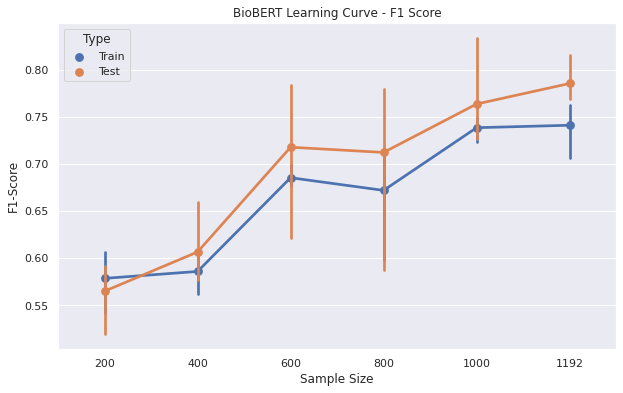

In [2]:

#### Comment these 2 following rows when fine-tuning the new model. Those are the record we have got. ####
training_f1_stats = [[0.5873336957365042, 0.607044453408894, 0.5418140202549756], [0.629760541669822, 0.5624554474328008, 0.5660370835978563], [0.6804009386582915, 0.6988955570573218, 0.677194031659202], [0.703997855880524, 0.7139529774894124, 0.5982375728220529], [0.7229922141385722, 0.7438250805546677, 0.7488639847104102], [0.7061236796327739, 0.7550873568367761, 0.7622543676367205]]
validation_f1_stats = [[0.5843910843689701, 0.5192204727145019, 0.5918206091580704], [0.659728568604066, 0.5835685151253484, 0.5770154350539136], [0.7487229491641257, 0.7833961587518089, 0.6214946476095857], [0.7793841581641145, 0.7700478307527795, 0.5875214509740366], [0.8337465878398769, 0.7262555598771679, 0.7310381485424738], [0.8156834023819318, 0.7694883251668966, 0.7712354806141569]]
##########################################################################################################


training_sizes= [200,400,600,800,1000,1192]

f_n_train = []
for n in training_sizes:
  for x in range(3):
    f_n_train.append(n)

f_train = []
for f in training_f1_stats:
  for ff in f:
    f_train.append(ff)

f_test = []
for f2 in validation_f1_stats:
  for ff2 in f2:
    f_test.append(ff2)

records = f_train + f_test
type1 = ['Train']*18
type2 = ['Test']*18
type_ = type1 + type2
n = f_n_train +f_n_train 

import pandas as pd
data_plot_f1 = pd.DataFrame({'n':n,'Data':records,'Type':type_})
## Construct Learning Curve ##
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)

sns.set_theme(style="darkgrid")
ax = sns.pointplot(x="n", y="Data", hue="Type",data=data_plot_f1)
ax.set(xlabel='Sample Size', ylabel='F1-Score',title ="BioBERT Learning Curve - F1 Score",)
plt.savefig('BioBERT_F1_Learning_Curve.png')
plt.show()
